# Cat and Dog Classification - week 5
Classify images of cats and dogs using Histogram of Oriented Gradients (HOG) for feature extraction and Decision Tree, Random Forest, Linear Regression for classification and compair them. 

In [9]:
import os
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [10]:
# Load dataset
data_dir = './dataset'
images, labels = [], []

for file in os.listdir(data_dir):
    if file.endswith('.jpg'):
        img_path = os.path.join(data_dir, file)
        if file.startswith('cat'):
            labels.append(0)  # Cat
        elif file.startswith('dog'):
            labels.append(1)  # Dog
        else:
            continue

        img = imread(img_path)
        img = rgb2gray(img)  # Convert to grayscale
        images.append(img)

images = np.array(images)
labels = np.array(labels)
print('Images shape:', images.shape)
print('Labels shape:', labels.shape)
print(f'Number of cats: {np.sum(labels == 0)}')
print(f'Number of dogs: {np.sum(labels == 1)}')

Images shape: (615, 128, 128)
Labels shape: (615,)
Number of cats: 260
Number of dogs: 355


In [11]:
# Extract HOG features
hog_features = []
hog_images = []
for img in images:
    features, hog_img = hog(
        img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        transform_sqrt=True,
        visualize=True
    )
    hog_features.append(features)
    hog_images.append(hog_img)

hog_features = np.array(hog_features)
hog_images = np.array(hog_images)
print('HOG features shape:', hog_features.shape)
print('HOG images shape:', hog_images.shape)

HOG features shape: (615, 8100)
HOG images shape: (615, 128, 128)


In [ ]:
# Split dataset into train and test
# TODO: First learn about input and output of train_test_split function, then pay attention to distribution of data.
# You may need to make data with equal number of dog and cat. What's your idea to do this?! 
#Undersampling :throw away extra samples from the bigger class.
# Oversampling : duplicate samples from the smaller class.
# Data Augmentation : create new variations of the smaller class images (rotate, flip, brightness changes, etc.).
# Stratified Split : ensures the train/test split keeps the same ratio, but it does not fix imbalance.

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    hog_features, labels, np.arange(len(labels)), test_size=0.2, random_state=42, stratify=labels
)
images_train = images[idx_train]
images_test = images[idx_test]
hog_images_train = hog_images[idx_train]
hog_images_test = hog_images[idx_test]

print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)
print(f'Training set - Cats: {np.sum(y_train == 0)}, Dogs: {np.sum(y_train == 1)}')
print(f'Test set - Cats: {np.sum(y_test == 0)}, Dogs: {np.sum(y_test == 1)}')

Training set shape: (492, 8100)
Test set shape: (123, 8100)
Training set - Cats: 208, Dogs: 284
Test set - Cats: 52, Dogs: 71


In [13]:
# TODO: Train models using scikit learn
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

# Linear Regression (convert regression output to binary classification)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_pred_lr = (y_pred_lr >= 0.5).astype(int)  # thresholding
lr_accuracy = accuracy_score(y_test, y_pred_lr)

print(f'Decision Tree Accuracy: {dt_accuracy:.4f}')
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')
print(f'Linear Regression Accuracy: {lr_accuracy:.4f}')

Decision Tree Accuracy: 0.8130
Random Forest Accuracy: 0.9350
Linear Regression Accuracy: 0.9106


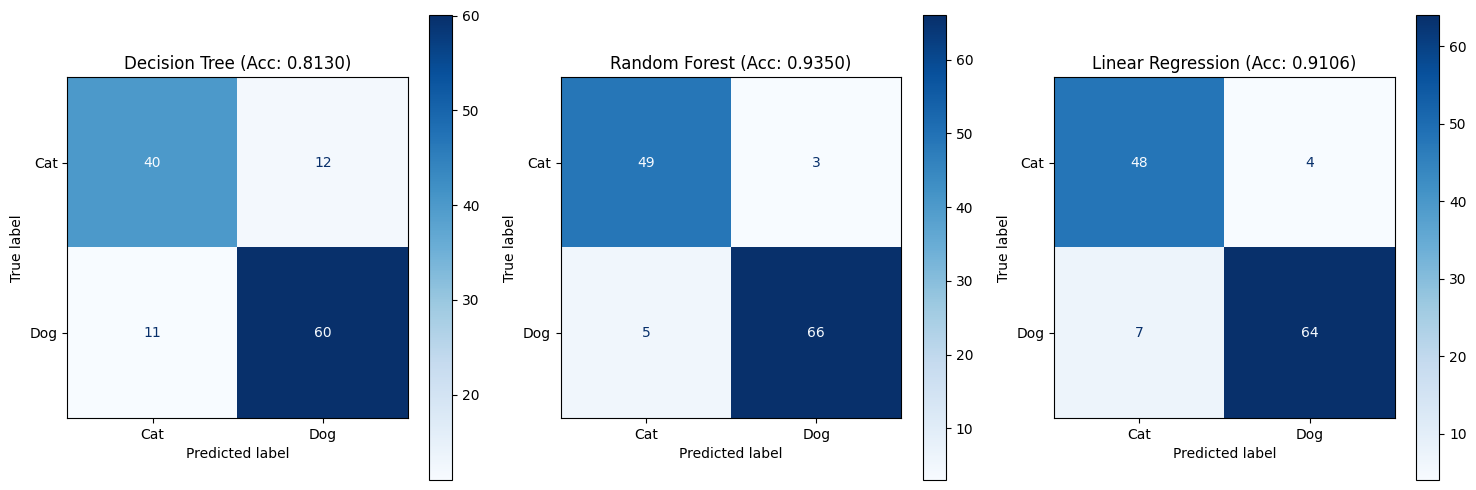

In [14]:
# Compare models with confusion matrices
# TODO: first of all learn that what is confusion martice is then complete cell

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay(cm_dt, display_labels=['Cat', 'Dog']).plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title(f'Decision Tree (Acc: {dt_accuracy:.4f})')

# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm_rf, display_labels=['Cat', 'Dog']).plot(ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title(f'Random Forest (Acc: {rf_accuracy:.4f})')

# Linear Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(cm_lr, display_labels=['Cat', 'Dog']).plot(ax=axes[2], cmap=plt.cm.Blues)
axes[2].set_title(f'Linear Regression (Acc: {lr_accuracy:.4f})')

# finally we show result
plt.tight_layout()
plt.show()

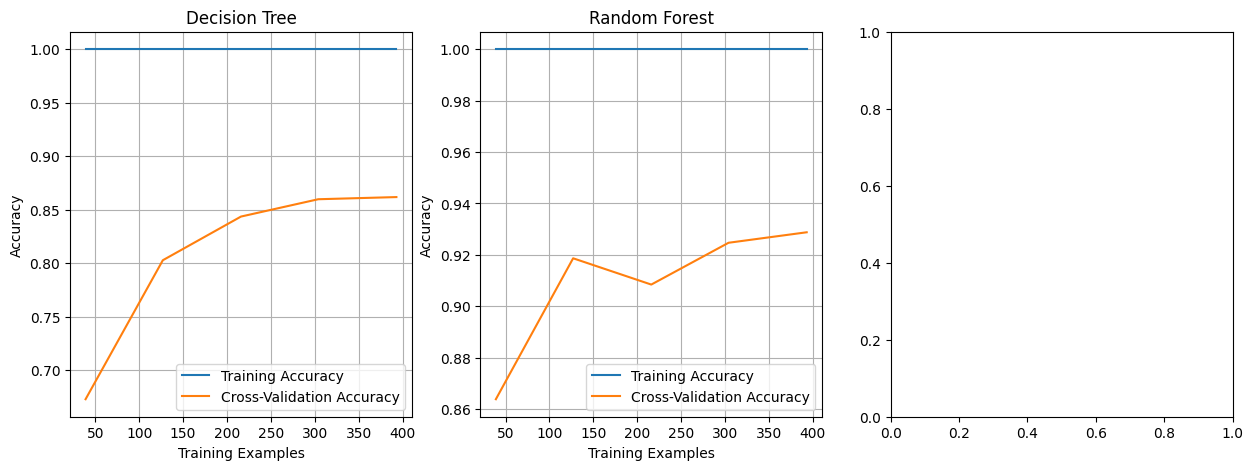

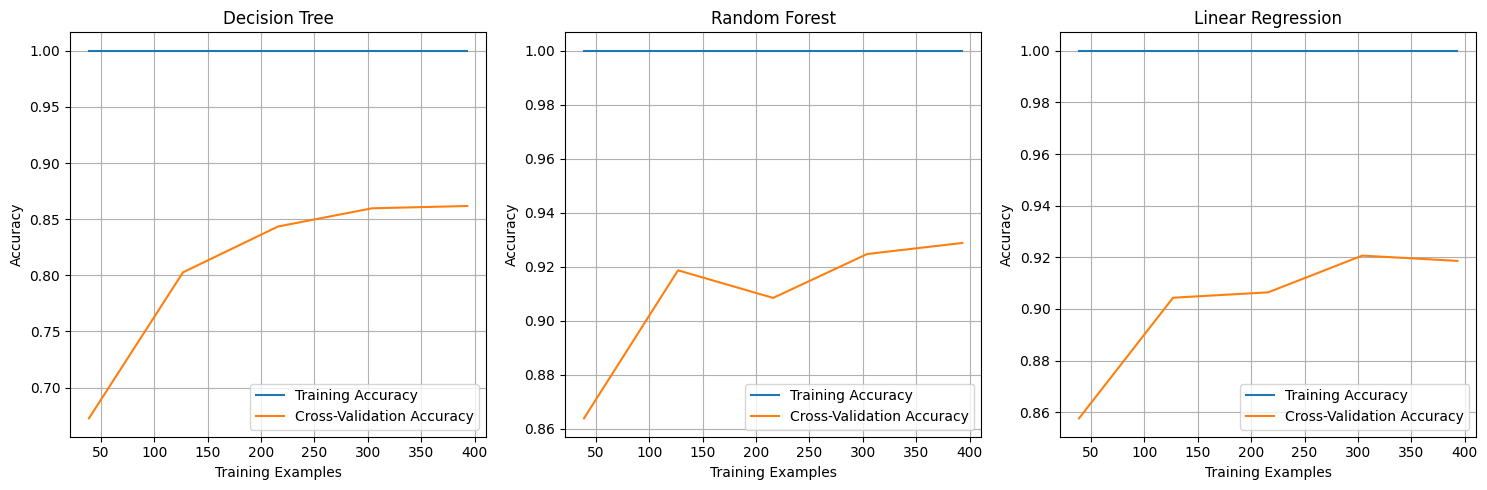

In [15]:
# Learning curves
# TODO: like confusion cell, first learn what Learning curves is, then complete cell.
def plot_learning_curve(estimator, title, X, y, ax, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=train_sizes, scoring='accuracy'
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    ax.plot(train_sizes, train_scores_mean, label='Training Accuracy')
    ax.plot(train_sizes, test_scores_mean, label='Cross-Validation Accuracy')
    ax.set_title(title)
    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Accuracy')
    ax.legend(loc='best')
    ax.grid(True)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# TODO: use plot_learning_curve function to show learning curve plots of all models.
# Decision Tree
plot_learning_curve(DecisionTreeClassifier(random_state=42),
                    "Decision Tree", X_train, y_train, axes[0])

# Random Forest
plot_learning_curve(RandomForestClassifier(random_state=42),
                    "Random Forest", X_train, y_train, axes[1])

class LinearRegClassifier(BaseEstimator, ClassifierMixin):
    """Wrap LinearRegression to behave like a classifier (with threshold)."""
    def __init__(self, threshold=0.5):
        self.threshold = threshold
        self.reg = LinearRegression()

    def fit(self, X, y):
        self.reg.fit(X, y)
        return self

    def predict(self, X):
        preds = self.reg.predict(X)
        return (preds >= self.threshold).astype(int)


def plot_learning_curve(estimator, title, X, y, ax, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=train_sizes, scoring='accuracy'
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    ax.plot(train_sizes, train_scores_mean, label='Training Accuracy')
    ax.plot(train_sizes, test_scores_mean, label='Cross-Validation Accuracy')
    ax.set_title(title)
    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Accuracy')
    ax.legend(loc='best')
    ax.grid(True)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_learning_curve(DecisionTreeClassifier(random_state=42), "Decision Tree", X_train, y_train, axes[0])
plot_learning_curve(RandomForestClassifier(random_state=42), "Random Forest", X_train, y_train, axes[1])
plot_learning_curve(LinearRegClassifier(threshold=0.5), "Linear Regression", X_train, y_train, axes[2])
plt.tight_layout()
plt.show()


### It seams there is wrong with Linear Regression learning curve, Can you guess why?!

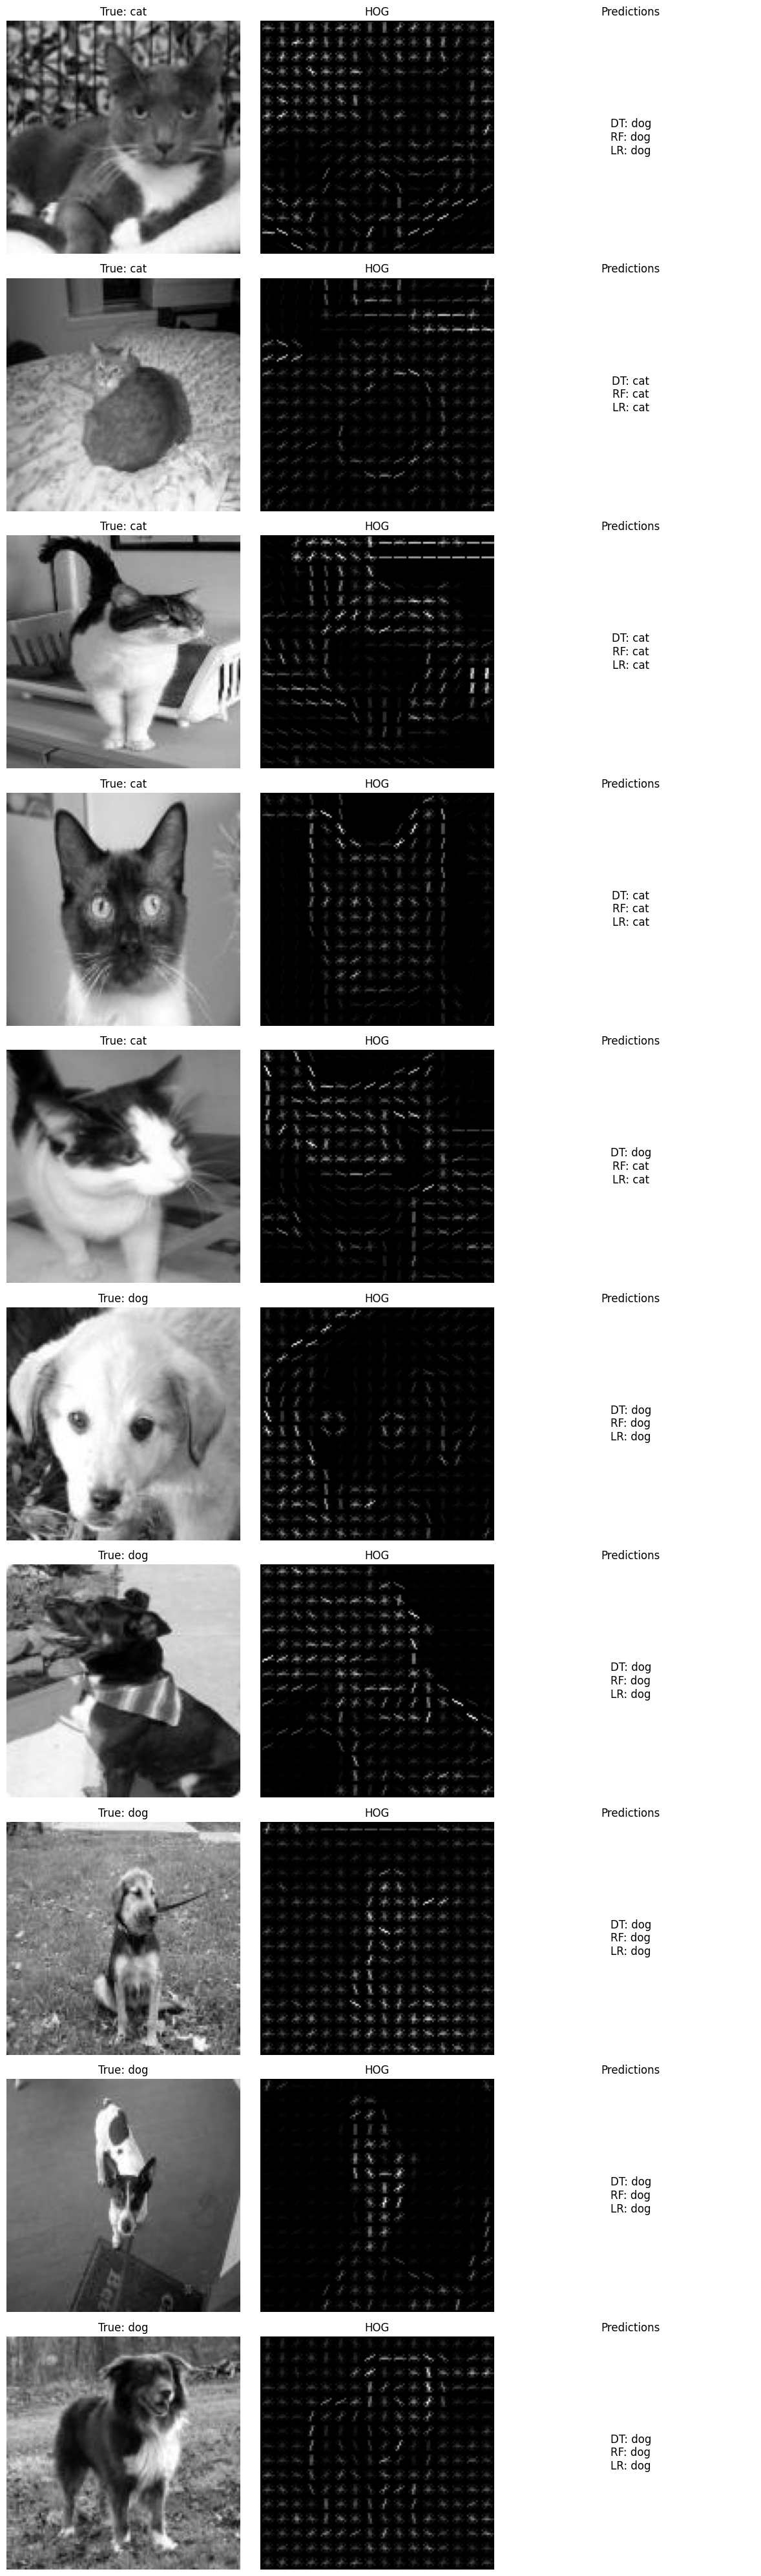

In [16]:
# Visualize sample results
classes = ['cat', 'dog']
cat_indices = [idx for idx in idx_test if y_test[np.where(idx_test == idx)[0][0]] == 0]
dog_indices = [idx for idx in idx_test if y_test[np.where(idx_test == idx)[0][0]] == 1]
sample_indices = cat_indices[:min(5, len(cat_indices))] + dog_indices[:min(5, len(dog_indices))]

fig, axes = plt.subplots(len(sample_indices), 3, figsize=(12, 4 * len(sample_indices)))
for i, idx in enumerate(sample_indices):
    pos = np.where(idx_test == idx)[0][0]
    true_label = y_test[pos]
    dt_pred_label = y_pred_dt[pos]
    rf_pred_label = y_pred_rf[pos]
    lr_pred_label = y_pred_lr[pos]
    # Original image
    ax = axes[i, 0] if len(sample_indices) > 1 else axes[0]
    ax.imshow(images_test[np.where(idx_test == idx)[0][0]], cmap='gray')
    ax.set_title(f'True: {classes[true_label]}')
    ax.axis('off')

    # HOG image
    ax = axes[i, 1] if len(sample_indices) > 1 else axes[1]
    ax.imshow(hog_images_test[np.where(idx_test == idx)[0][0]], cmap='gray')
    ax.set_title('HOG')
    ax.axis('off')

    # Predictions
    ax = axes[i, 2] if len(sample_indices) > 1 else axes[2]
    ax.text(0.5, 0.5, f'DT: {classes[dt_pred_label]}\nRF: {classes[rf_pred_label]}\nLR: {classes[lr_pred_label]}',
            fontsize=12, ha='center', va='center')
    ax.set_title('Predictions')
    ax.axis('off')

plt.tight_layout()
plt.show()